In [16]:
%run '../ipython_startup.py'

pjoin = os.path.join

Importing commonly used libraries: 
            os, sys 
            numpy as np 
            scipy as sp 
            pandas as pd 
            matplotlib as mp 
            matplotlib.pyplot as plt
            datetime as dt 
            mclib_Python/flagging as fg

Creating project level variables: 
        MCLAB = /home/jfear/mclab 
        PROJ = /home/jfear/mclab/cegs_ase_paper 
        TODAY = 20160113

Adding ['scripts/mclib_Python', 'scripts/ase_Python'] to PYTHONPATH

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from sas7bdat import SAS7BDAT as sas
from sklearn.neighbors import DistanceMetric
import seaborn
from itertools import combinations


In [18]:
fname = pjoin(PROJ, 'sas_data/cis_est_v13.sas7bdat')
with sas(fname) as FH:
    est_df = FH.to_data_frame()

[cis_est_v13.sas7bdat] header length 65536 != 8192
[cis_est_v13.sas7bdat] [cis_est_v13.sas7bdat] header length 65536 != 8192


In [19]:
est_df.columns

Index([u'line', u'mating_status', u'fusion_id', u'q4_mean_theta',
       u'q5_mean_theta', u'q6_mean_theta', u'qsim_mean_theta', u'flag_q4_AI',
       u'flag_q5_AI', u'flag_q6_AI', u'flag_all_AI', u'flag_AI_qsim',
       u'flag_AI_combined', u'qsim_tester', u'sum_line', u'sum_tester',
       u'sum_both', u'sum_total', u'mean_apn', u'COUNT', u'PERCENT',
       u'sum_ase', u'line1', u'tester1', u'diff', u'test', u'_FREQ_',
       u'pop_sum_line', u'pop_sum_tester', u'C_t', u'sum_all', u'allele_mean',
       u'c_i', u'T_t_1', u'T_i_1a', u'T_t_2', u'T_i_2a', u'T_t_3', u'T_i_3a',
       u'direction_cis', u'direction_trans'],
      dtype='object')

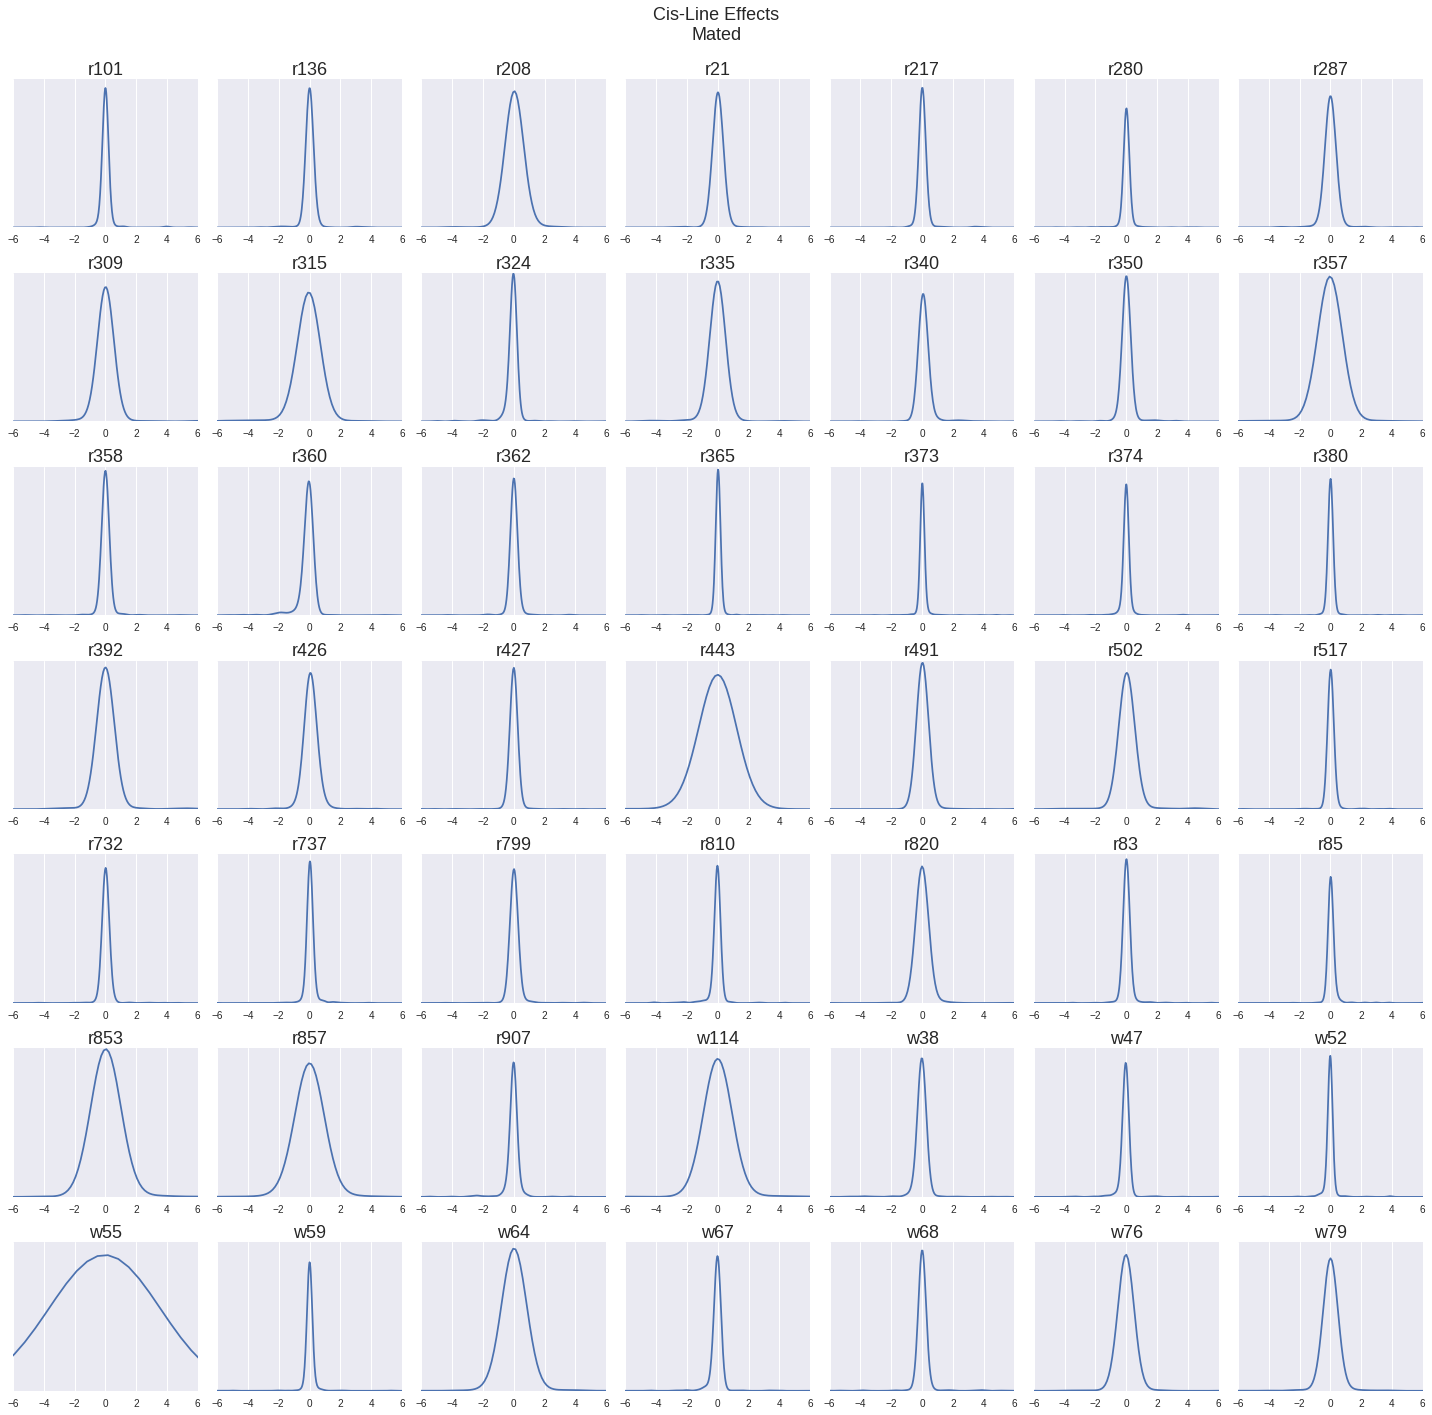

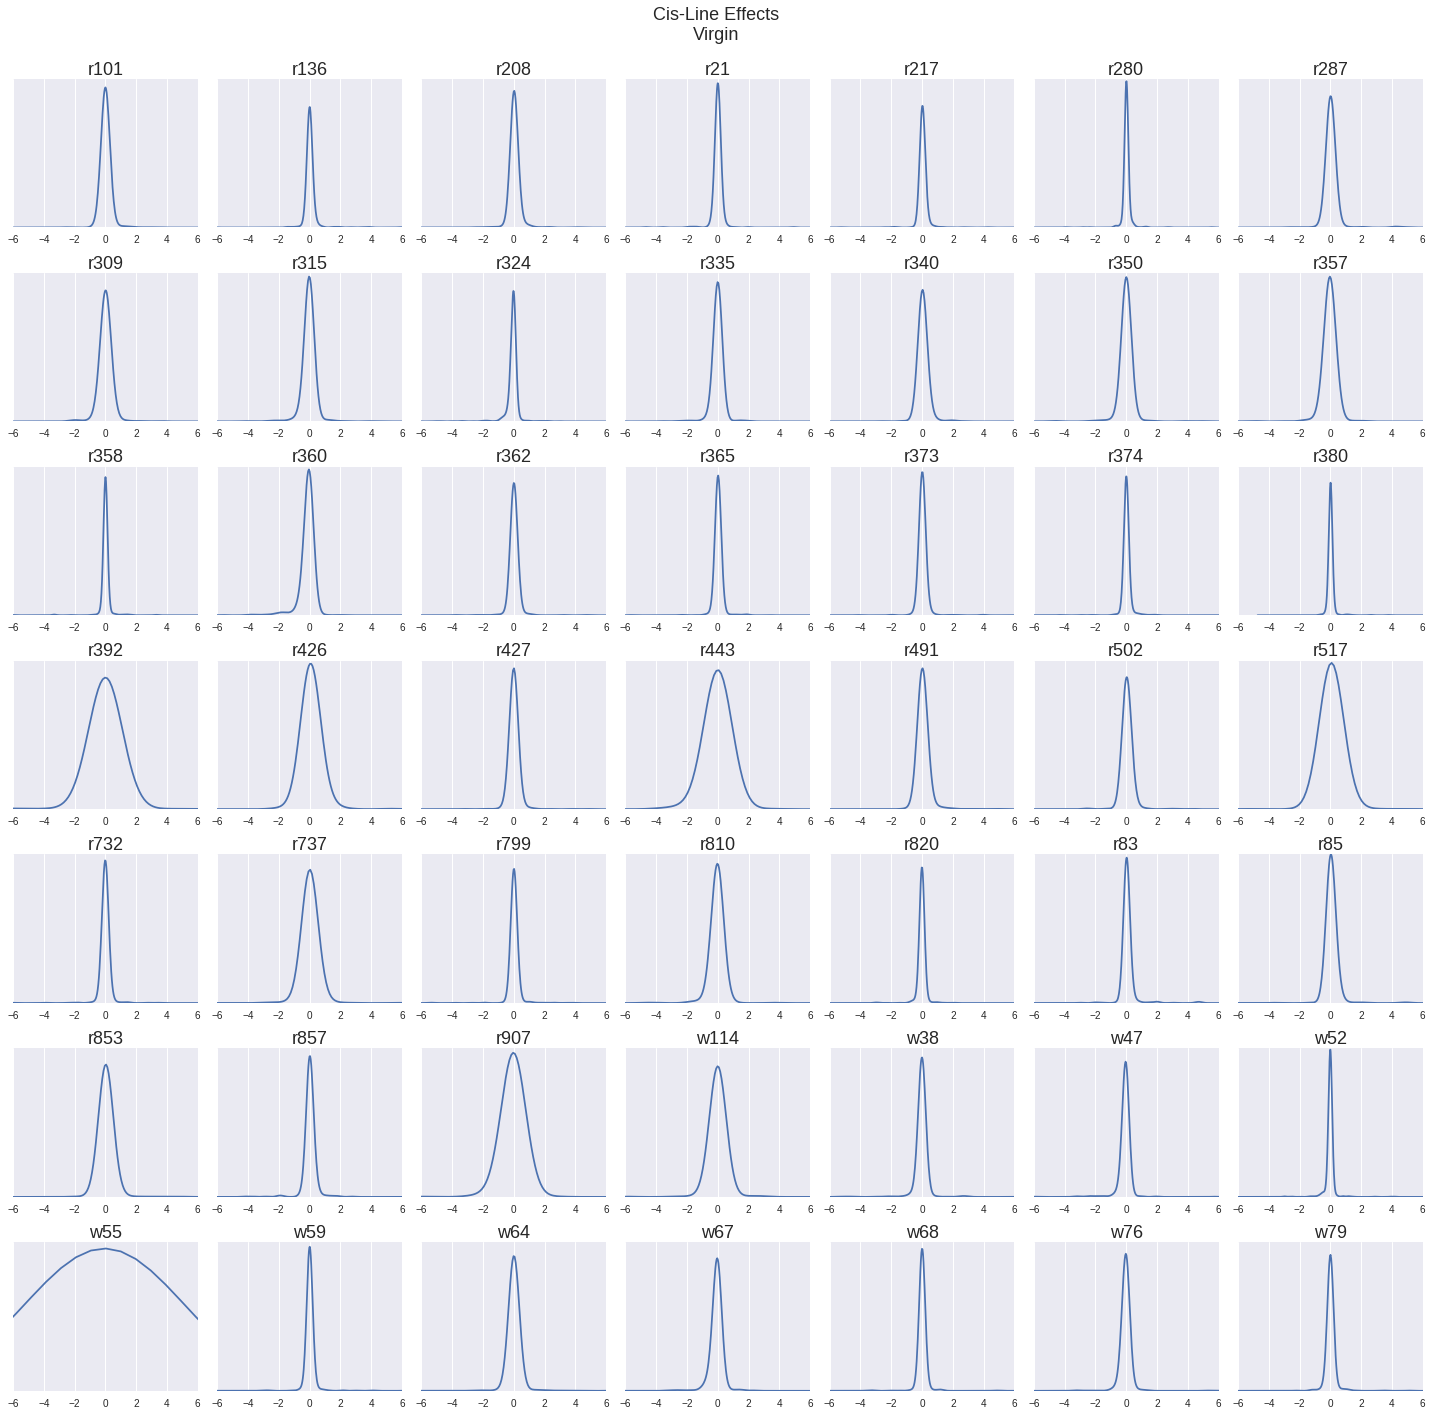

In [20]:
# Figure 2
convert = {'M': 'Mated', 'V': 'Virgin'}
for m, d in est_df.groupby('mating_status'):
    fig, axes = plt.subplots(7, 7, figsize=(20, 20))
    axes = axes.ravel()
    fig.suptitle('Cis-Line Effects\n{}'.format(convert[m]), fontsize=18)
    
    cnt = 0
    for l, f in d.groupby('line'):
        ax = axes[cnt]
        f['c_i'].plot(kind='kde', ax=ax)
        ax.set_title(l, fontsize=18)
        ax.yaxis.set_visible(False)
        ax.set_xlim(-6, 6)
        cnt += 1
    plt.tight_layout(rect=[0, 0, 1, .95])
    fig.savefig(pjoin(PROJ, 'pipeline_output/cis_effects/lauren_est_density_plot_by_genotype_c_i_{}.png'.format(convert[m].lower())))
    fig.savefig(pjoin(PROJ, 'pipeline_output/cis_effects/lauren_est_density_plot_by_genotype_c_i_{}.svg'.format(convert[m].lower())), format='svg')

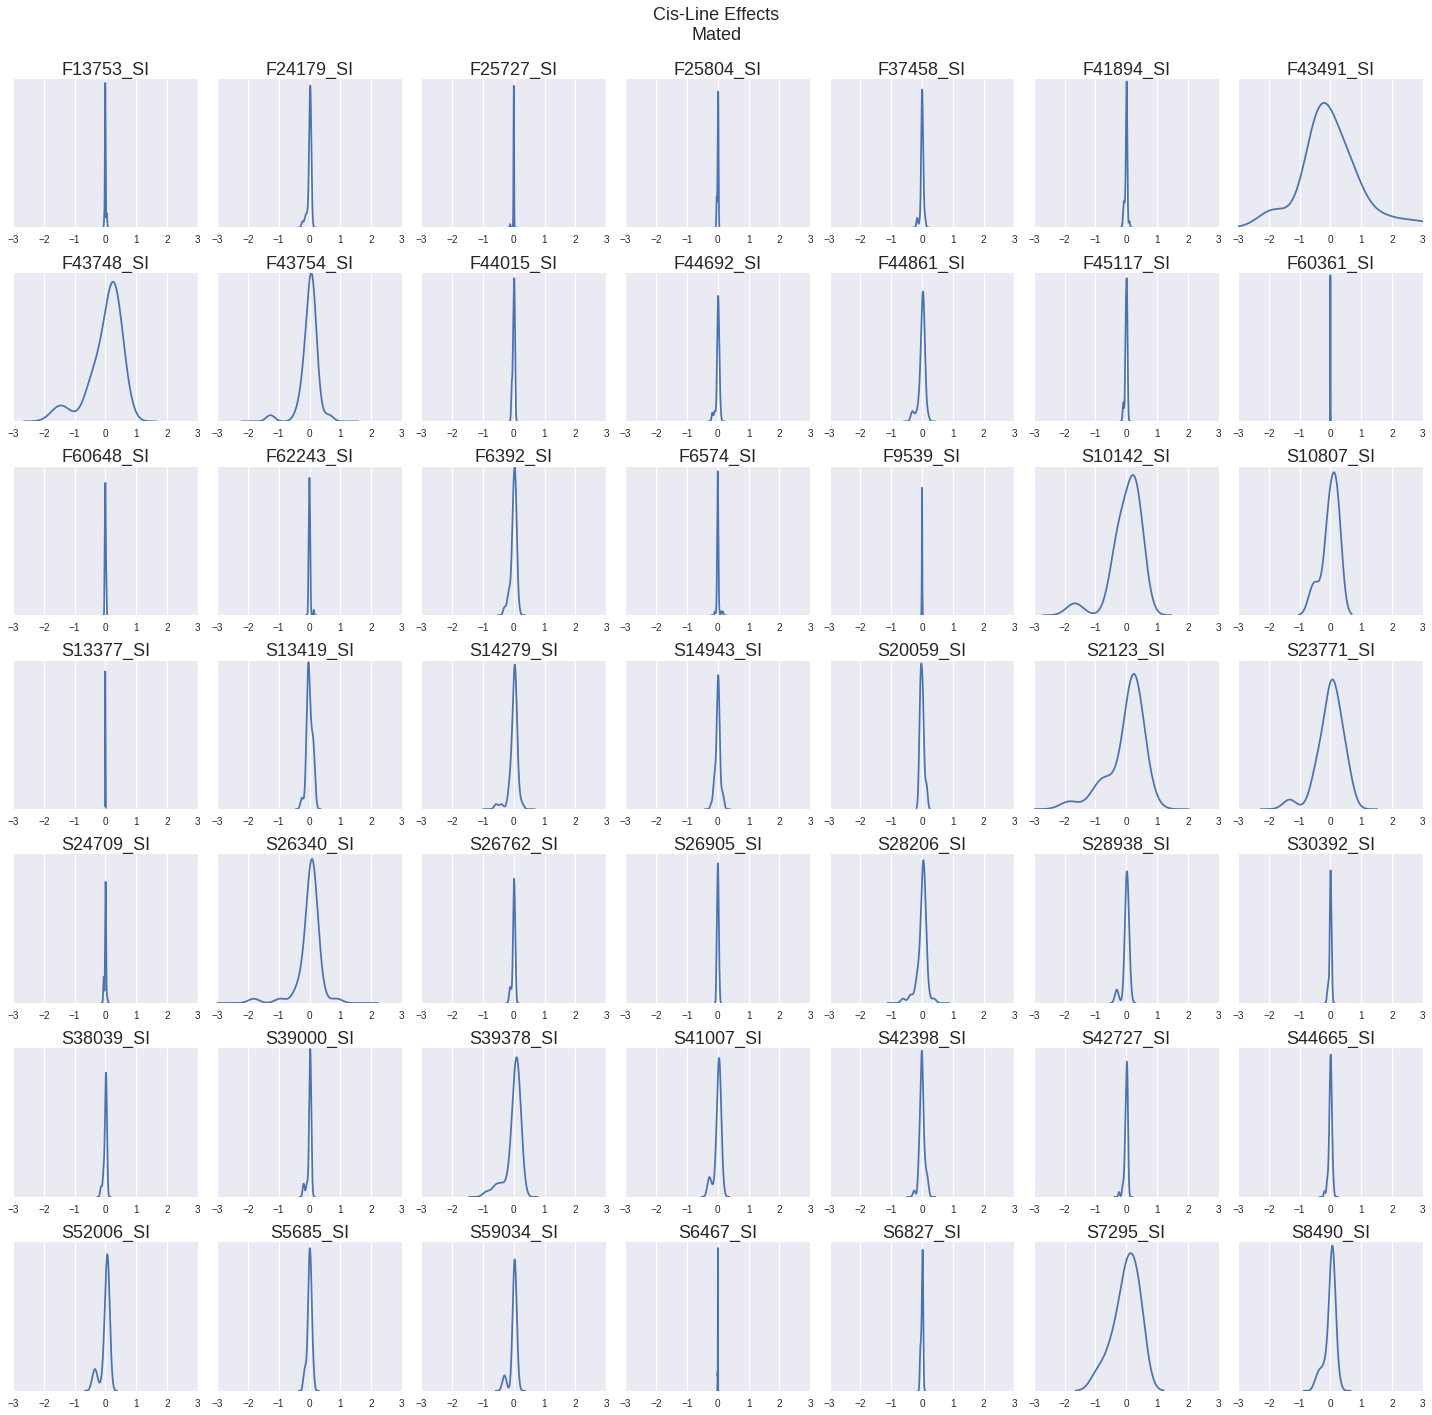

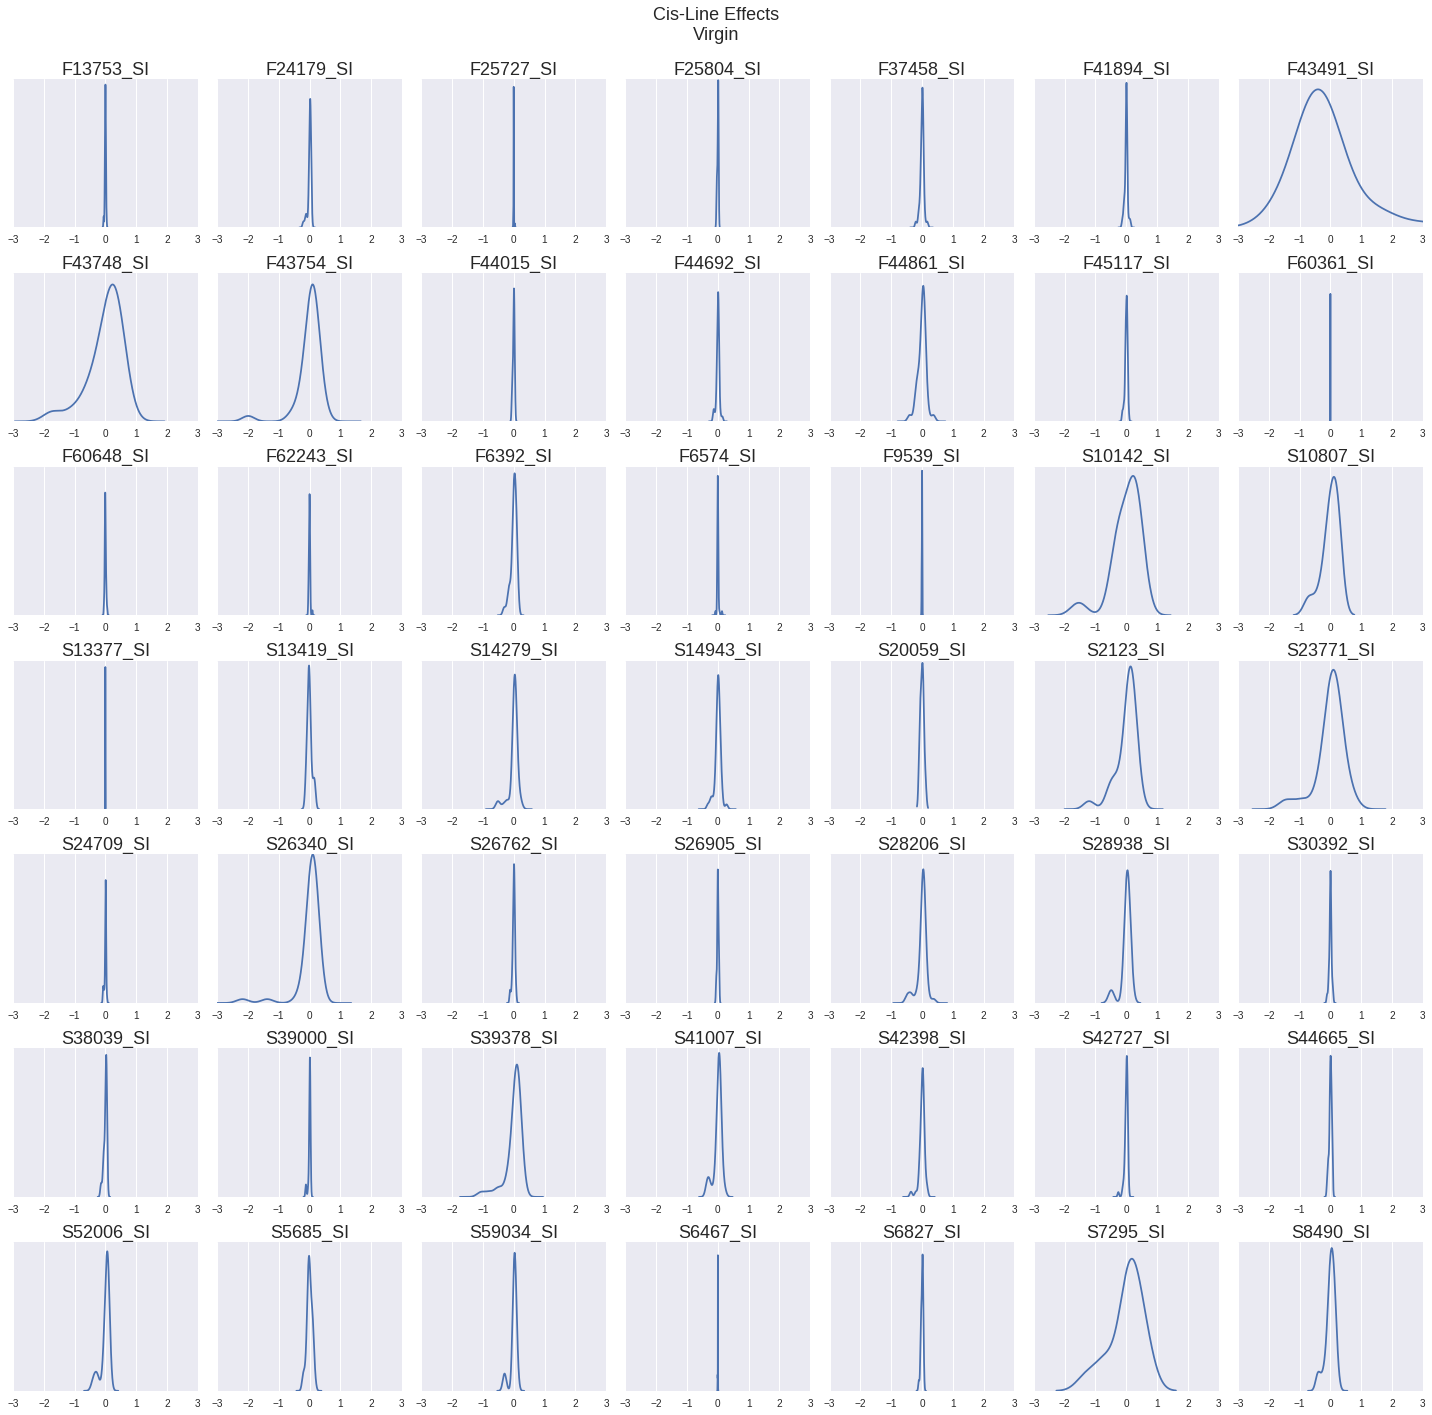

In [21]:
# Figure 4
convert = {'M': 'Mated', 'V': 'Virgin'}

## Pull out 49 randomm fusions
np.random.seed(4242)
fus = list(set(est_df['fusion_id'].tolist()))
sel_fus = np.random.choice(fus, size=49, replace=False)
df = est_df[est_df['fusion_id'].isin(sel_fus)]

for m, d in df.groupby('mating_status'):
    fig, axes = plt.subplots(7, 7, figsize=(20, 20))
    axes = axes.ravel()
    fig.suptitle('Cis-Line Effects\n{}'.format(convert[m]), fontsize=18)
    
    cnt = 0
    for l, f in d.groupby('fusion_id'):
        ax = axes[cnt]
        f['c_i'].plot(kind='kde', ax=ax)
        ax.set_title(l, fontsize=18)
        ax.yaxis.set_visible(False)
        ax.set_xlim(-3, 3)
        cnt += 1
    plt.tight_layout(rect=[0, 0, 1, .95])
    fig.savefig(pjoin(PROJ, 'pipeline_output/cis_effects/lauren_est_density_plot_by_exonic_region_c_i_{}.png'.format(convert[m].lower())))
    fig.savefig(pjoin(PROJ, 'pipeline_output/cis_effects/lauren_est_density_plot_by_exonic_region_c_i_{}.svg'.format(convert[m].lower())), format='svg')

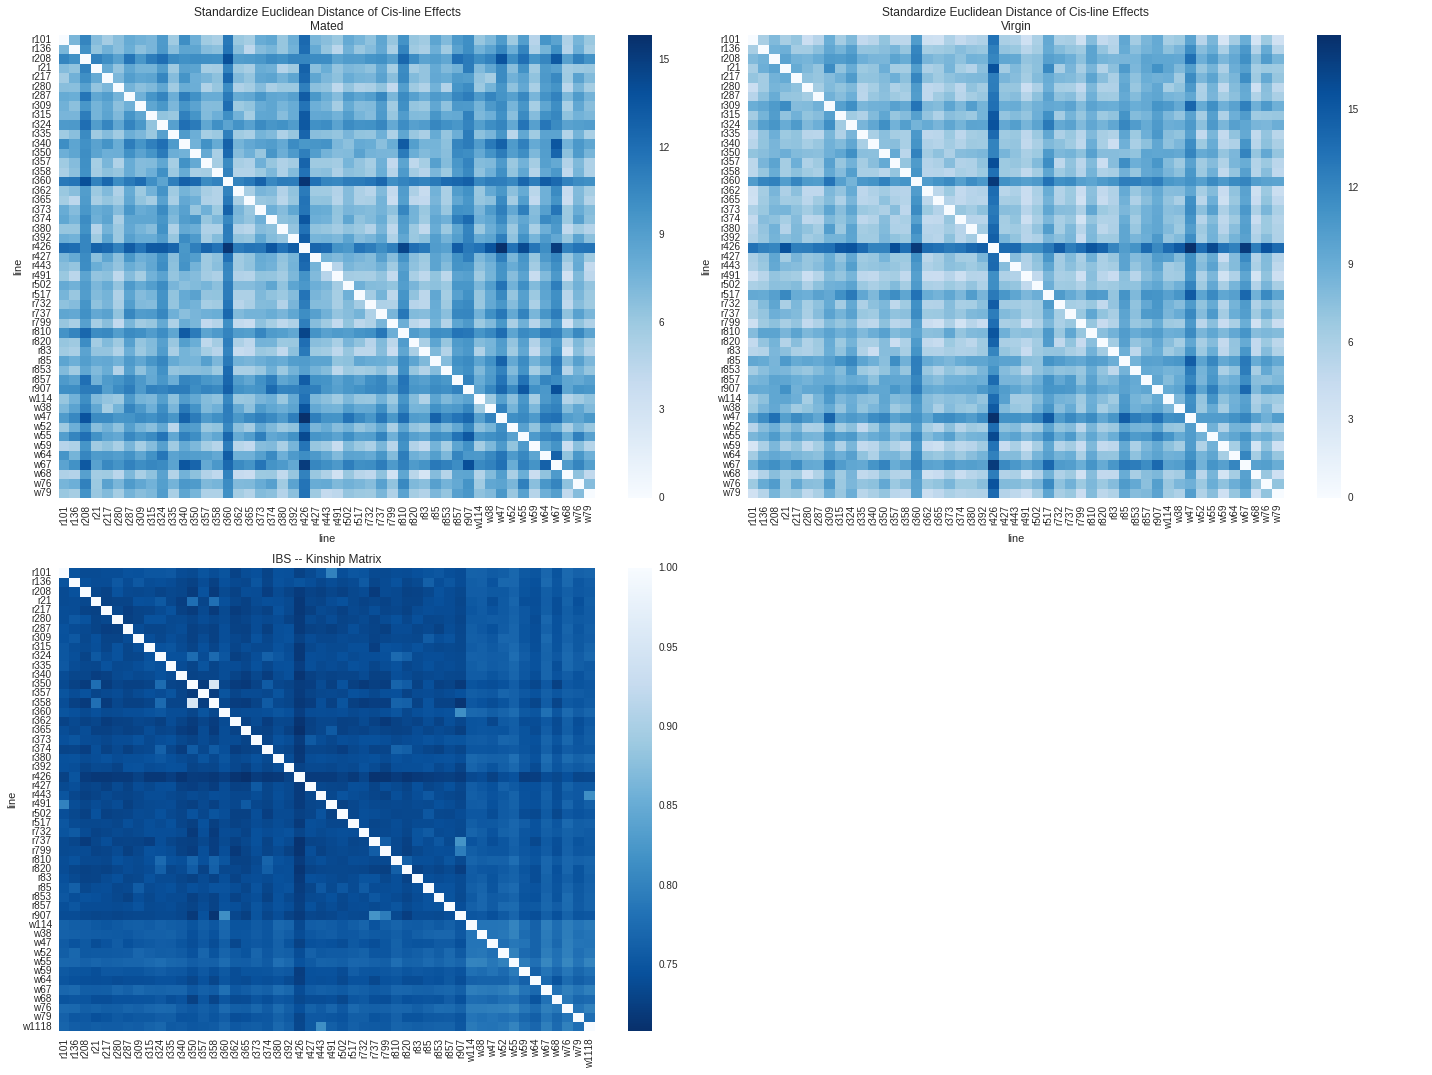

In [23]:
# Figure 5

# Import kjong's kinship matrix
kin = pd.read_csv('../../pipeline_output/similarity/kinship_matrix.csv')
kin.set_index('Unnamed: 0', inplace=True)
kin.index.name='line'

# Mated Euclidean Distance
mated = est_df[est_df['mating_status'] == 'M']
flip = mated.pivot_table(values='c_i', index='fusion_id', columns='line')
flip.dropna(axis=0, inplace=True)

# Calculate the variance of each Fusion
sigmahat = flip.T.var()

# Create a standardized euclidean distance object where sigma is equal to our sigmahat
seuc = DistanceMetric.get_metric('seuclidean', V=sigmahat)

# Calculate pairwise distances between genotypes and make dataframe
dist = seuc.pairwise(flip.T)
dfDistM = pd.DataFrame(dist, columns=flip.columns, index=flip.columns)

# Virgin Euclidean Distance
virgin = est_df[est_df['mating_status'] == 'V']
flip = virgin.pivot_table(values='c_i', index='fusion_id', columns='line')
flip.dropna(axis=0, inplace=True)

# Calculate the variance of each Fusion
sigmahat = flip.T.var()

# Create a standardized euclidean distance object where sigma is equal to our sigmahat
seuc = DistanceMetric.get_metric('seuclidean', V=sigmahat)

# Calculate pairwise distances between genotypes and make dataframe
dist = seuc.pairwise(flip.T)
dfDistV = pd.DataFrame(dist, columns=flip.columns, index=flip.columns)


# Plot heatmaps
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Heatmap of distance (cis-line effects)
seaborn.heatmap(dfDistM, cmap='Blues', ax=ax1)
ax1.set_title('Standardize Euclidean Distance of Cis-line Effects\nMated')

seaborn.heatmap(dfDistV, cmap='Blues', ax=ax2)
ax2.set_title('Standardize Euclidean Distance of Cis-line Effects\nVirgin')

# Heatmap of kinship
seaborn.heatmap(kin.loc[dfDistM.columns.tolist() + ['w1118', ], dfDistM.columns.tolist() + ['w1118', ]], ax=ax3, cmap='Blues_r')
_ = ax3.set_title('IBS -- Kinship Matrix')

# clear the last axis
_ = ax4.axis('off')

plt.tight_layout()
fig.savefig(os.path.join(PROJ, 'pipeline_output/cis_effects/lauren_heatmap_std_euclidean_and_kinship.png'))
fig.savefig(os.path.join(PROJ, 'pipeline_output/cis_effects/lauren_heatmap_std_euclidean_and_kinship.svg'), format='svg')

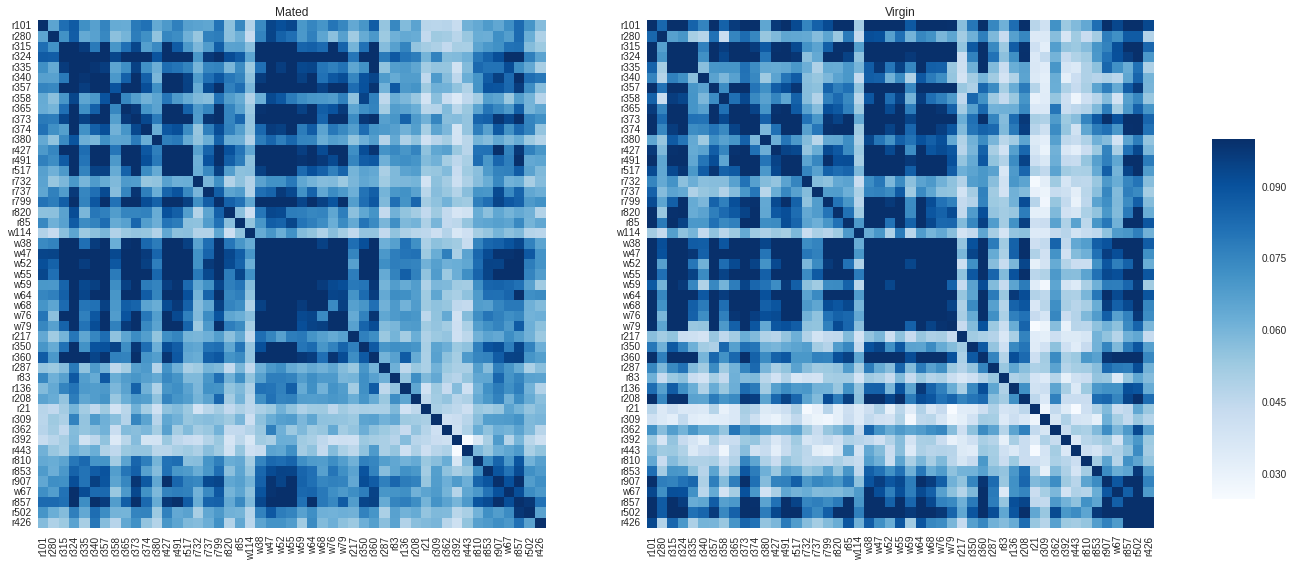

In [24]:
# Purple Figure


def loop(df, func):
    """ This is a general looping function. 
    
    Creates and iterates over all pairwise combinations. Filters 
    dataframe and passes it to the given function. This will make it 
    easy to run various distance metrics.
    
    """
    # get list of lines
    lines = df['line'].factorize()[1]
    
    # Create matrix to store distance results
    dfResults = pd.DataFrame(np.eye(lines.shape[0], lines.shape[0]), columns=lines, index=lines)
    
    #Iterate over all pairwise combinations
    for combo in combinations(lines, 2):
        
        # Create dataframe for current combination
        dfCurr = df[(df['line'] == combo[0]) | (df['line'] == combo[1])]
        
        # Pass dataframe to my function of choice
        res = func(dfCurr)
        
        # Fill in results matrix
        dfResults.loc[combo[0], combo[1]] = res
        dfResults.loc[combo[1], combo[0]] = res

    return dfResults

def AI_dist(df):
    """ Calculate the proporiton of fusions that both had AI in a pairwise combination. """
    # Create a 2 column side-by-side dataframe with fusion_id as rows and lines and columns.
    dfSbs = df[['line', 'fusion_id', 'flag_AI_combined']].set_index(['fusion_id', 'line']).unstack()
    
    # Sum flag_AI_combined across lines, if equals 2 then both lines had AI
    dfSum = dfSbs.sum(axis=1)
    
    # Number of fusions that both had AI
    num = dfSum[dfSum == 2].shape[0]
    
    # How many fusions did we test, after removing NaN
    total = dfSum.dropna().shape[0]
    
    return num / float(total)


# Split by MS
mated = est_df[est_df['mating_status'] == 'M']
virgin = est_df[est_df['mating_status'] == 'V']

# Calculate pairwise proportion of overlap of AI
aiMated = loop(mated, AI_dist)
aiVirgin = loop(virgin, AI_dist)

# make heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
cbar_ax = fig.add_axes([.94, .2, .03, .5])

seaborn.heatmap(aiMated, vmax=0.1, square=True, ax=ax1, cbar=False, cmap='Blues')
ax1.set_title('Mated')

seaborn.heatmap(aiVirgin, vmax=0.1, square=True, ax=ax2, cbar_ax=cbar_ax, cmap='Blues')
ax2.set_title('Virgin')

fig.savefig(os.path.join(PROJ, 'pipeline_output/cis_effects/lauren_heatmap_ai_distance.png'))
fig.savefig(os.path.join(PROJ, 'pipeline_output/cis_effects/lauren_heatmap_ai_distance.svg'), format='svg')